In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
df = pd.read_csv('powergrid_material_demand_latest.csv')
df.head()

,Project_ID,Location,Geographic_Region,Budget_Cr,Tower_Count,Substations_Count,Steel_Demand_Tons,Conductor_Demand_Km,Insulator_Demand_Nos,Transformer_Demand_Units,Tower_Type,Substation_Type,Terrain_Difficulty,Tax_Rate,Start_Year,Completion_Year,Line_Length_CKM,Transformation_Capacity_MVA
0,PROJ-2201,Bihar,Northern Plains,1833.0,1727,1,51903.042929,4134,259050,3,D/C 765 kV,AIS,Medium,12,2020,2023,689,2823
1,PROJ-8551,Delhi,Northern Plains,2351.0,2777,2,97195.000000,2916,66648,5,S/C 220 kV,AIS,Medium,18,2021,2024,972,4835
2,PROJ-5595,Rajasthan,Desert Plains,1283.0,846,2,25380.000000,888,17604,1,S/C 220 kV,GIS,Medium,18,2018,2020,296,500
3,PROJ-7077,Delhi,Northern Plains,1445.0,1058,2,31740.000000,2538,76176,1,D/C 400 kV,Hybrid,Low,12,2014,2018,423,1601
4,PROJ-5024,Gujarat,Desert Plains,1242.0,1540,2,46200.000000,1386,36960,4,S/C 220 kV,AIS,High,12,2015,2017,462,3399


In [3]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', categorical_cols)

for col in categorical_cols:
    if col != 'Project_ID': 
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

print('Missing values per column:')
print(df.isnull().sum())

Categorical columns: ['Project_ID', 'Location', 'Geographic_Region', 'Tower_Type', 'Substation_Type', 'Terrain_Difficulty']
Missing values per column:
Project_ID                     0
Location                       0
Geographic_Region              0
Budget_Cr                      0
Tower_Count                    0
Substations_Count              0
Steel_Demand_Tons              0
Conductor_Demand_Km            0
Insulator_Demand_Nos           0
Transformer_Demand_Units       0
Tower_Type                     0
Substation_Type                0
Terrain_Difficulty             0
Tax_Rate                       0
Start_Year                     0
Completion_Year                0
Line_Length_CKM                0
Transformation_Capacity_MVA    0
dtype: int64


In [4]:
input_features = ['Location', 'Geographic_Region', 'Tower_Count', 'Substations_Count', 'Tower_Type', 'Substation_Type',
                   'Tax_Rate', 'Line_Length_CKM', 'Transformation_Capacity_MVA', 'Budget_Cr']
output_features = ['Steel_Demand_Tons', 'Conductor_Demand_Km', 'Insulator_Demand_Nos', 'Transformer_Demand_Units']
X = df[input_features]
y = df[output_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)

Train shape: (4620, 10) Test shape: (1155, 10)


In [5]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
for i, col in enumerate(output_features):
    print(f'Output: {col}')
    print('MSE:', mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print('R2:', r2_score(y_test.iloc[:, i], y_pred[:, i]))
    print('-'*30)

Output: Steel_Demand_Tons
MSE: 35882093.24676115
R2: 0.9836805120576553
------------------------------
Output: Conductor_Demand_Km
MSE: 9814.267326233768
R2: 0.9986666047781497
------------------------------
Output: Insulator_Demand_Nos
MSE: 67813446.71051757
R2: 0.9968854198350751
------------------------------
Output: Transformer_Demand_Units
MSE: 0.6924083982683982
R2: 0.4878602600923714
------------------------------


In [6]:
# Feature importance analysis (single output, since importances are averaged in multi-output RF)
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]
print('Feature importances (averaged across all outputs):')
for idx in sorted_idx:
    print(f'{feature_names[idx]}: {importances[idx]:.4f}')

Feature importances (averaged across all outputs):
Tower_Count: 0.5230
Tower_Type: 0.4358
Line_Length_CKM: 0.0227
Budget_Cr: 0.0100
Transformation_Capacity_MVA: 0.0068
Substation_Type: 0.0011
Location: 0.0003
Geographic_Region: 0.0002
Substations_Count: 0.0001
Tax_Rate: 0.0001


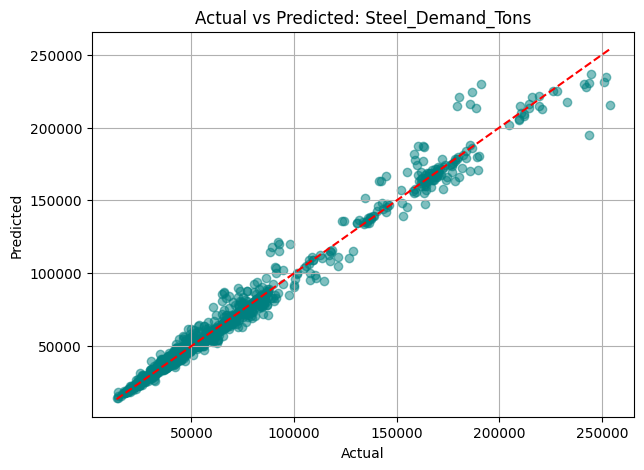

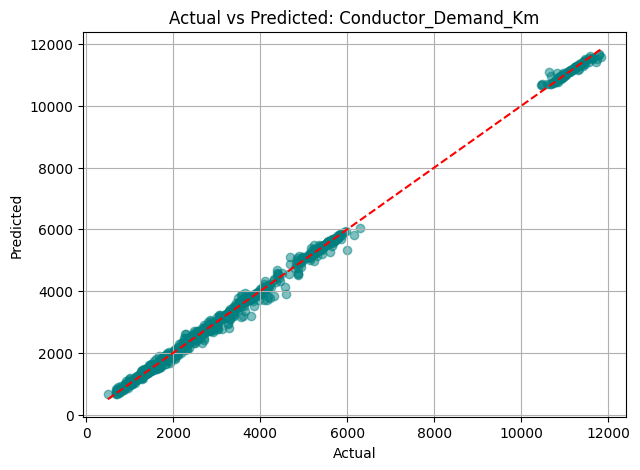

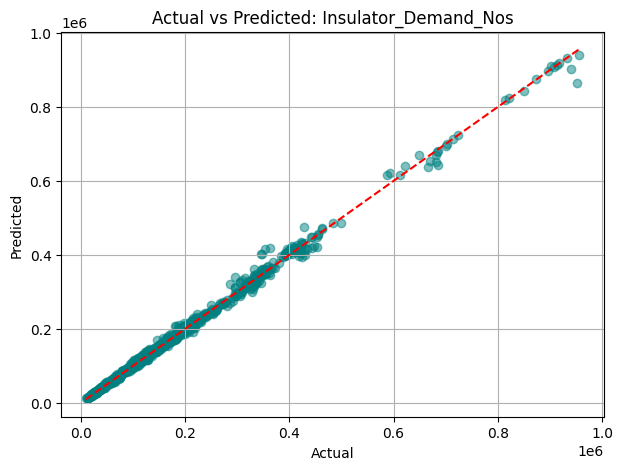

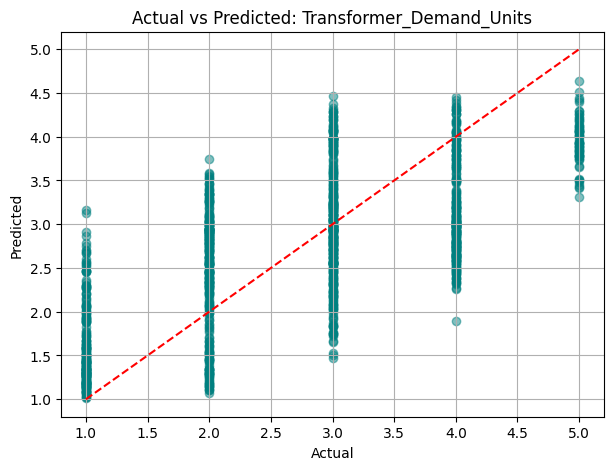

In [7]:
import matplotlib.pyplot as plt
for i, col in enumerate(output_features):
    plt.figure(figsize=(7,5))
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5, color='teal')
    plt.plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted: {col}')
    plt.grid(True)
    plt.show()

In [8]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Cross-validated R2 scores:', cv_scores)
print('Mean R2:', cv_scores.mean())

Cross-validated R2 scores: [0.86678873 0.86988677 0.85866267 0.86765941 0.85598254]
Mean R2: 0.8637960256897201
